# Discover the Higgs with Deep Neural Networks

The input data was created from 13 TeV ATLAS open data available at http://opendata.atlas.cern/release/2020/documentation/index.html

For more information read:<br>
Review of the 13 TeV ATLAS Open Data release, Techn. Ber., All figures including auxiliary figures are available at https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PUBNOTES/ATL-OREACH-PUB-2020-001: CERN, 2020, url: http://cds.cern.ch/record/2707171

The data is measured by the ATLAS detector, one of the four big detectors at the Large Hadron Collider (LHC) at the CERN research center:

![ATLAS_detector.png](figures/ATLAS_detector.png)
ATLAS Experiment © 2008 CERN

The data analyzed in this jupyter notebook measured at a centre-of-mass energy of $\sqrt{s}=13 \text{ TeV}$ with an integrated luminosity of $10 \text{ fb}^{-1}$ in the year 2016. To search for H$\rightarrow$ZZ$\rightarrow$llll events only events with four reconstructed leptons in the final state are included in the given data sets. The events will have a event signature similar to:

![ATLAS_four_lepton_event.png](figures/ATLAS_four_lepton_event.png)
https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/CONFNOTES/ATLAS-CONF-2011-162/

## Data Preparation

### Load the Data

In [1]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from numpy.random import seed
import os

# Random state
random_state = 12 #12345
_ = np.random.RandomState(random_state)

In [2]:
import common

The goal of this lab course is to train a deep neural network to separate Higgs boson signal from background events. The most important signal sample ggH125_ZZ4lep corresponds to the process gg$\rightarrow$H$\rightarrow$ZZ. The dominant background sample is llll resulting from Z and ZZ decays.
After training the DNN model will be used to classify the events of the data samples.

Higgs signal samples:
- ggH125_ZZ4lep
- VBFH125_ZZ4lep
- WH125_ZZ4lep
- ZH125_ZZ4lep

Background samples:
- llll
- Zee
- Zmumu
- ttbar_lep

Data samples:
- data_A
- data_B
- data_C
- data_D

In [3]:
# Define the input samples
sample_list_signal = ['ggH125_ZZ4lep']
sample_list_background = ['llll']
sample_list_signal = ['ggH125_ZZ4lep', 'VBFH125_ZZ4lep', 'WH125_ZZ4lep', 'ZH125_ZZ4lep']
sample_list_background = ['llll', 'Zee', 'Zmumu', 'ttbar_lep']
sample_list_measured = ['data_A', 'data_B', 'data_C', 'data_D']

In [4]:
sample_path = 'input'
# Read all the samples
no_selection_data_frames = {}
for sample in sample_list_signal + sample_list_background + sample_list_measured:
    no_selection_data_frames[sample] = pd.read_csv(os.path.join(sample_path, sample + '.csv'))

### Input Variables

The input provides several variables to classify the events. Since each event has multiple leptons, they were ordered in descending order based on their transverse momentum. Thus, lepton 1 has the highest transverse momentum, lepton 2 the second highest, and so on. <br>
Most of the given variables can be called low-level, because they represent event or object properties, which can be derived directly from the reconstruction in the detector. In contrast to this are high-level variables, which result from the combination of several low-level variables. In the given dataset the only high-level variables are invariant masses of multiple particles:<br>
$m_{inv} = \sqrt{\left(\sum\limits_{i=1}^{n} E_i\right)^2 - \left(\sum\limits_{i=1}^{n} \vec{p}_i\right)^2}$


List of all available variables:<br>
- Event number
 - Each simulated event has its own specific number. (not used for training)
 - Variable name: eventNumber
- Scale and event weight
 - The scaling for a data set is given by the sum of event weights, the cross section, luminosity and a efficiency scale factor
 - Each event has an additional specific event weight
 - To combine simulated events and finally compare them to data each event has to be scaled by the total weight, the product of scale weight and event weight
 - The weight are not used for training
 - Variable name: scaleWeight, eventWeight, totalWeight
- Number of jets
 - Jets are particle showers which result primarily from quarks and gluons
 - Variable name: jet_n
- Invariant four lepton mass
 - The invariant mass $m_{inv}(l_1, l_2, l_3, l_4)$ is the reconstructed invariant mass of the full four lepton event. This variable is to be displayed later but not used for training.
 - Variable name: lep_m_llll
- Invariant two lepton mass
 - Invariant masses $m_{inv}(l_i, l_j)$ of all combinations of two leptons
 - Variable names: lep_m_ll_12, lep_m_ll_13, lep_m_ll_14, lep_m_ll_23, lep_m_ll_24, lep_m_ll_34
- Transverse momentum $p_T$ of the leptons
 - The momentum in the plane transverse to the beam axis
 - Variable names: lep1_pt, lep2_pt, lep3_pt, lep4_pt
- Lepton azimuthal angle
 - The azimuthal angle $\phi$ is measured in the plane transverse to the beam axis
 - Variable name: lep1_phi, lep2_phi, lep3_phi, lep4_phi
- Lepton pseudo rapidity
 - The angle $\theta$ is measured between the lepton track and the beam axis. Since this angle is not invariant against boosts along the beam axis, the pseudo rapidity $\eta = - \ln{\tan{\frac{\theta}{2}}}$ is primarily used in the ATLAS analyses
 - Variable names: lep1_eta, lep2_eta, lep3_eta, lep4_eta
- Lepton energy
 - The energy of the leptons reconstructed from the calorimeter entries
 - Variable name: lep1_e, lep2_e, lep3_e, lep4_e
- Lepton PDG-ID
 - The lepton type is classified by a n umber given by the Particle-Data-Group. The lepton types are $pdg-id(e)=11$, $pdg-id(\mu)=13$ and $pdg-id(\tau)=15$
 - Variable name: lep1_pdgId, lep2_pdgId, lep3_pdgId, lep4_pdgId
- Lepton charge
 - The charge of the given lepton reconstructed by the lepton track
 - Variable name: lep1_charge, lep2_charge, lep3_charge, lep4_charge

### Event Pre-Selection

Before we start with the pre-selection of the input data check the number of events per process.

In [5]:
# Loop over all processes
for sample in sample_list_signal + sample_list_background:
    # Sum over the weights is equal to the number of expected events
    n_events = sum(no_selection_data_frames[sample]['totalWeight'])
    # Number of raw simulation events
    n_events_raw = len(no_selection_data_frames[sample]['totalWeight'])
    print(f'{sample}: {round(n_events, 2)}; {n_events_raw} (raw)')

ggH125_ZZ4lep: 8.87; 164716 (raw)
VBFH125_ZZ4lep: 0.8; 191126 (raw)
WH125_ZZ4lep: 0.35; 15379 (raw)
ZH125_ZZ4lep: 0.0; 14485 (raw)
llll: 280.61; 554279 (raw)
Zee: 170.33; 898 (raw)
Zmumu: 139.34; 684 (raw)
ttbar_lep: 85.66; 1031 (raw)


Although the final selection of the data is to be performed on the basis of a DNN, a rough pre-selection of the data is still useful.
For this purpose, selection criteria are defined, which return either true or false based on the event kinematics and thus decide whether the respective event is kept or discarded.
Suitable criteria for this analysis are very basic selections that must be clearly fulfilled by H->ZZ->llll processes.

<font color='blue'>
Task: Find baseline selection criteria that reduce the background while keeping almost all Higgs events. 
</font>


Hint: What lepton types and charges are expected in the final state?

In [6]:
def cut_lep_type(lep_type_0, lep_type_1, lep_type_2, lep_type_3):
    """Only keep lepton type combinations resulting from H->ZZ->llll"""
    # Select events like eeee, mumumumu or eemumu
    sum_lep_type = lep_type_0 + lep_type_1 + lep_type_2 + lep_type_3
    return sum_lep_type == 44 or sum_lep_type == 48 or sum_lep_type == 52


def cut_lep_charge(lep_charge_0, lep_charge_1, lep_charge_2, lep_charge_3):
    """Only keep lepton charge combinations resulting from H->ZZ->llll"""
    # Select events where the sum of all lepton charges is zero
    sum_lep_charge = lep_charge_0 + lep_charge_1 + lep_charge_2 + lep_charge_3
    return sum_lep_charge == 0

In [7]:
# Create a copy of the original data frame to investigate later
data_frames = no_selection_data_frames.copy()

# Apply the chosen selection criteria
for sample in sample_list_signal + sample_list_background + sample_list_measured:
    # Selection on lepton type
    type_selection = np.vectorize(cut_lep_type)(
        data_frames[sample].lep1_pdgId,
        data_frames[sample].lep2_pdgId,
        data_frames[sample].lep3_pdgId,
        data_frames[sample].lep4_pdgId)
    data_frames[sample] = data_frames[sample][type_selection]

    # Selection on lepton charge
    charge_selection = np.vectorize(cut_lep_charge)(
        data_frames[sample].lep1_charge,
        data_frames[sample].lep2_charge,
        data_frames[sample].lep3_charge,
        data_frames[sample].lep4_charge)
    data_frames[sample] = data_frames[sample][charge_selection]

<font color='blue'>
Check wether your selection criteria have the required effects 
</font>

In [8]:
# Loop over all processes
for sample in sample_list_signal + sample_list_background:
    # Sum over the weights is equal to the number of expected events
    n_events = sum(data_frames[sample]['totalWeight'])
    # Number of raw simulation events
    n_events_raw = len(data_frames[sample]['totalWeight'])
    print(f'{sample}: {round(n_events, 2)}; {n_events_raw} (raw)')

ggH125_ZZ4lep: 8.7; 161451 (raw)
VBFH125_ZZ4lep: 0.78; 186870 (raw)
WH125_ZZ4lep: 0.22; 9772 (raw)
ZH125_ZZ4lep: 0.0; 11947 (raw)
llll: 266.55; 523957 (raw)
Zee: 43.42; 243 (raw)
Zmumu: 52.33; 257 (raw)
ttbar_lep: 28.31; 334 (raw)


If you are happy with you baseline selection continue with the investigation of the data.

### Data Investigation

Before one can decide which variables are suitable for training, one must first get a feel for the input variables.
For this purpose, the input samples are merged into a set of signal events and a set of background events. Afterwards, the behavior of signal and background can be studied in multiple variables.

In [9]:
# Merge the signal and background data frames
def merge_data_frames(sample_list, data_frames_dic):
    for sample in sample_list:
        if sample == sample_list[0]:
            output_data_frame = data_frames_dic[sample]
        else:
            output_data_frame = pd.concat([output_data_frame, data_frames_dic[sample]], axis=0)
    return output_data_frame

data_frame_signal = merge_data_frames(sample_list_signal, data_frames)
data_frame_background = merge_data_frames(sample_list_background, data_frames)
data_frame_measured = merge_data_frames(sample_list_measured, data_frames)

The function common.plot_hist(variable, data_frame_1, data_frame_2) plots the given variable of the two data sets.
The variable must be a dictionary containing atleast the variable to plot. Additionally one can also specify the binning (list or numpy array) and the xlabel. The created histogram is automatically saved in the plots directory<br>

<font color='blue'>
Task: Which variable is the most discriminant? Which variables seem not discriminant at all? 
</font><br>

<font color='green'>
Answer:

- Most discriminant is the invariant mass of the four lepton system $m_{inv}(l_1, l_2, l_3, l_4)$ with a peak at the Higgs mass of 125 GeV.
- The angualar variables $\phi$ are not sensitive to any process due to the symmetry of the detector.
</font>

An example for the transverse momnetum of the leading lepton is given below:

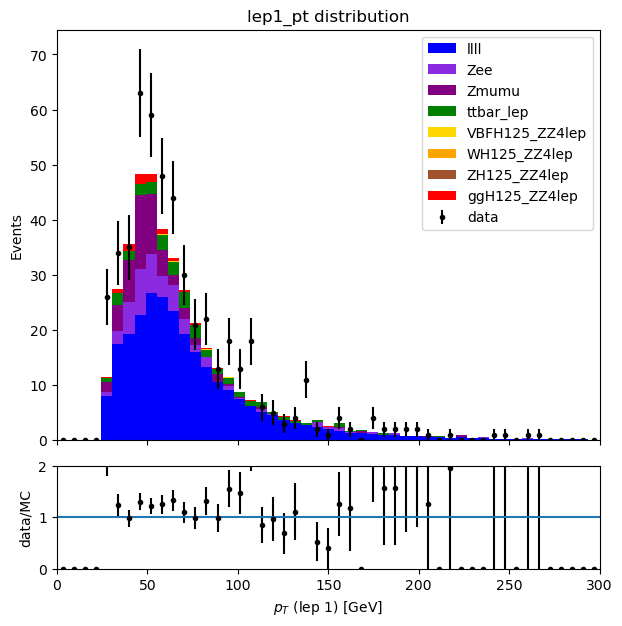

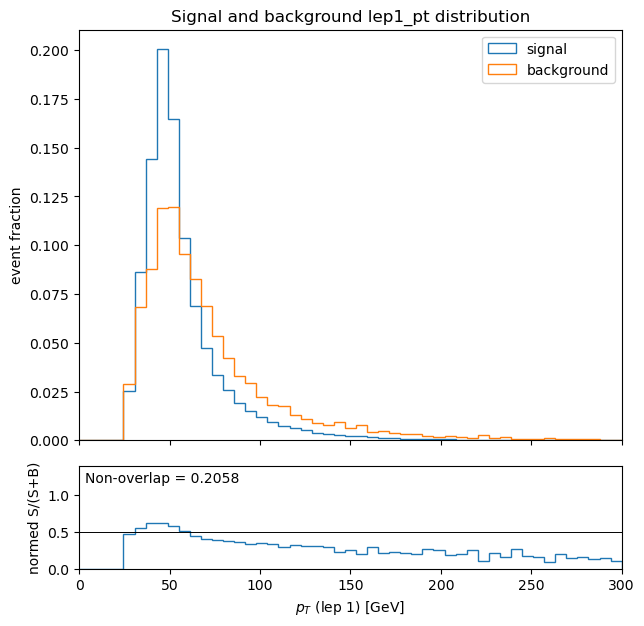

In [10]:
# leading lepton pt
var_lep1_pt = {'variable': 'lep1_pt',
               'binning': np.linspace(0, 300, 50),
               'xlabel': '$p_T$ (lep 1) [GeV]'}

common.plot_hist(var_lep1_pt, data_frames)
common.plot_normed_signal_vs_background(var_lep1_pt, data_frame_signal, data_frame_background)

<font color='blue'>
Task: What is the purity in signal events in the given data?
</font><br>

In [11]:
signal_event_number = sum(data_frame_signal.totalWeight)
background_event_number = sum(data_frame_background.totalWeight)
signal_background_ratio = signal_event_number/background_event_number
print(f'There are {round(signal_event_number, 2)} signal ({len(data_frame_signal)} raw MC events) and {round(background_event_number, 2)} backgound events ({len(data_frame_background)} raw MC events)\nThis gives a purity of {round(signal_background_ratio*100, 2)}%')

There are 9.7 signal (370040 raw MC events) and 390.61 backgound events (524791 raw MC events)
This gives a purity of 2.48%


As one could already see, the number of simulated raw events is significantly higher than the weighted number of expected events. The contribution of a simulated event to the final prediction is thus given by the respective event weight.

<font color='blue'>
Task: How many raw events are included in each process simulation and what the corresponding total prediction? What the is minimal, median, maximal event weight of each process?
</font><br>

In [12]:
for sample in sample_list_signal + sample_list_background:
    print(f'{sample}:')
    n_events = sum(data_frames[sample]['totalWeight'])
    n_events_raw = len(data_frames[sample]['totalWeight'])
    n_events_neg = sum(data_frames[sample]['totalWeight'] * (data_frames[sample]['totalWeight'] < 0))
    n_events_neg_raw = sum(list(data_frames[sample]['totalWeight'] < 0))
    min_weight = data_frames[sample]['totalWeight'].min()
    med_weight = data_frames[sample]['totalWeight'].median()
    max_weight = data_frames[sample]['totalWeight'].max()
    print(f'  Raw events:      {n_events_raw}')
    print(f'  Prediction:      {round(n_events, 2)}')
    print(f'  Neg. raw events: {round(100 * n_events_neg_raw / n_events_raw, 2)}%')
    print(f'  Neg. events:     {abs(round(100 * n_events_neg / n_events, 2))}%')
    print(f'  Minimal weight:  {min_weight}')
    print(f'  Median weight:   {med_weight}')
    print(f'  Maximal weight:  {max_weight}')
    print()

ggH125_ZZ4lep:
  Raw events:      161451
  Prediction:      8.7
  Neg. raw events: 0.21%
  Neg. events:     0.22%
  Minimal weight:  -0.0001097871068996
  Median weight:   6.0487756518639094e-05
  Maximal weight:  0.0002235023285485

VBFH125_ZZ4lep:
  Raw events:      186870
  Prediction:      0.78
  Neg. raw events: 0.18%
  Neg. events:     0.19%
  Minimal weight:  -8.226283411076771e-06
  Median weight:   4.693477814100141e-06
  Maximal weight:  1.707267083872427e-05

WH125_ZZ4lep:
  Raw events:      9772
  Prediction:      0.22
  Neg. raw events: 0.0%
  Neg. events:     0.0%
  Minimal weight:  0.0
  Median weight:   2.4991409279835305e-05
  Maximal weight:  8.08094179970647e-05

ZH125_ZZ4lep:
  Raw events:      11947
  Prediction:      0.0
  Neg. raw events: 0.0%
  Neg. events:     0.0%
  Minimal weight:  0.0
  Median weight:   1.420687246809822e-07
  Maximal weight:  4.585081735318556e-07

llll:
  Raw events:      523957
  Prediction:      266.55
  Neg. raw events: 10.36%
  Neg. ev

The different processes were simulated with different accuracy. To model 267 $llll$ events more than half a million raw events are used but 96 Z$\rightarrow ll$ is modelled by only 500 events.

Furthermore, it seems that the event weights even go into the negative range. Negative weighted events are produced to compensate overshooting predictions in certain kinematic areas.

## Choice of the Training Setup

In this part of the notebook we will create and train some simple neural networks. The goal is to find the right setup for training, as this is a basic requirement for successful training.

### How to Create and Train a Neural Network

Lets start with a very simple training on the transverse momentum of the leptons. To speed up the training not all processes are considered for the training.

In [13]:
# The training input variables
training_variables = ['lep1_pt', 'lep2_pt', 'lep3_pt', 'lep4_pt']
# Use only a subset of the full data
sample_subset_signal = ['ggH125_ZZ4lep']
sample_subset_background = ['llll', 'Zee', 'Zmumu']

Extract the training variables, the event weights, and the classification of the events. The classification is 0 for background processes and 1 for Higgs events. 
To further speed up the setup test only use 40% of the available data.

In [14]:
values, weights, classification = common.get_dnn_input(data_frames, training_variables, sample_subset_signal, sample_subset_background, 0.4)

In [15]:
# Show values of 5 random events
random_idx = [1841, 11852, 63217, 78357, 131697]
# Training variables
print('Training values:')
print(values[random_idx])
# Event weights
print('Event weights:')
print(weights[random_idx])
# Classification
print('Classification:')
print(classification[random_idx])

Training values:
[[ 50.69762109  14.5129248   14.10426074  11.05434961]
 [ 72.79403125  62.96560937  22.16645898  15.09641797]
 [ 67.23349219  25.31585937   9.48626074   7.40181104]
 [ 27.93245312  19.20275586  14.57376953  13.22955176]
 [129.05734375  78.68390625  44.70970703  41.84229688]]
Event weights:
[6.89296507e-05 4.35248947e-05 7.26105677e-05 1.68254793e-04
 1.43944749e-04]
Classification:
[1. 1. 1. 0. 0.]


Tensorflow is used to create and train neural networks. For this purpose, the required module is imported and the existing training values and classifications are transformed into a Tensorflow data set.

In [16]:
# Import the tensorflow module to create a DNN
import tensorflow as tf
from tensorflow.data import Dataset

In [17]:
# Convert the data to tensorflow datasets
train_data = Dataset.from_tensor_slices((values, classification))
train_data = train_data.shuffle(len(values), seed=random_state)
# Set the batch size
train_data = train_data.batch(128)

Metal device set to: Apple M1 Pro


So lets create a neural network consisting of several layers.

A full list of layer types can be found here https://www.tensorflow.org/api_docs/python/tf/keras/layers <br>
Some important examples for layers are:
- Normalization: Shift and scale the training input to have the center at 0 and a standard deviation of 1 
- Dense: a densely connected NN layer
- Dropout: randomly sets input to 0. Can decrease overtraining

The neurons of each layer are activated by the so called activation function. <br>
A full list of provided activation functions can be found here https://www.tensorflow.org/api_docs/python/tf/keras/activations <br>
Some examples are:
- Linear: $linear(x) = x$
- Relu: $relu(x) = max(0, x)$
- Exponential: $exponential(x) = e^x$
- Sigmoid: $sigmoid(x) = 1 / (1 + e^{-x})$

Let's create following model:
![simple_model.png](figures/simple_model.png)

- The input variables are scaled and shifted to have the mean of 0 and the standard deviation of 1. This normalization improves the convergence of the training process.
- Use two dense layers with 60 neurons each. The neurons are activated with the relu function.
- To classify background and signal the last layer should only consist of one neuron which has an activation between 0 and 1. The activation between 0 and 1 if given by the sigmoid function

In [18]:
# Normalization layer
normalization_layer = tf.keras.layers.Normalization(name='Input_normalization')
normalization_layer.adapt(values)

2023-04-29 15:19:21.066904: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [19]:
# Create model
model_layers = [
    normalization_layer,
    tf.keras.layers.Dense(60, activation='relu', name='Hidden_layer_1'),
    tf.keras.layers.Dense(60, activation='relu', name='Hidden_layer_2'),
    tf.keras.layers.Dense(1, activation='sigmoid', name='Output_layer'),
]
model = tf.keras.models.Sequential(model_layers, name='simple_model')

Before we start the training of the model lets check the shape and the number of trainable parameters.

In [20]:
# Display the model's architecture
model.summary()

Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_normalization (Normal  (None, 4)                9         
 ization)                                                        
                                                                 
 Hidden_layer_1 (Dense)      (None, 60)                300       
                                                                 
 Hidden_layer_2 (Dense)      (None, 60)                3660      
                                                                 
 Output_layer (Dense)        (None, 1)                 61        
                                                                 
Total params: 4,030
Trainable params: 4,021
Non-trainable params: 9
_________________________________________________________________


# How to get the number of parameters???

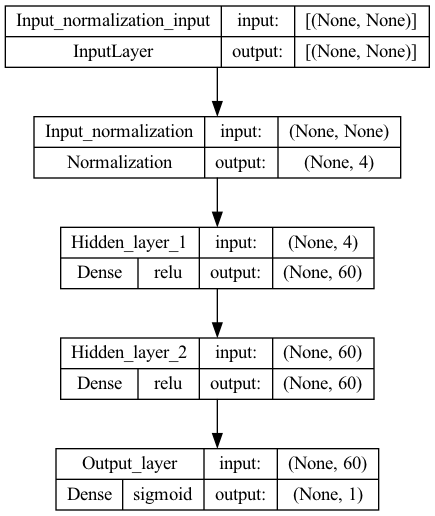

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True)

For the training we have to choose an optimization criteria, the loss function. For supervised learning, the loss function returns a value for the divergence between model prediction and the true value. The loss value is high for bad agreement and low for good agreement. Thus, training the model means minimizing the loss function.
The seperartion of signal and background is binary classification problem and thus the binary cross-entropy is used to calculate the loss.
The binary cross-entropy is given by:
$H = -\frac{1}{N} \sum_i^N (y_i^{true} log(y_i^{predict}) + (1 - y_i^{true}) log(1 - y_i^{predict}))$

As you can see the formula distinguishes signal events with $y_i^{true} = 1$ and background events with $y_i^{true} = 0$. In the following figure you can see the cross entropy for a signal and a background event for different prediction values. The closer the prediction value is to the true classification the smaller the crossentropy is. This is exactly the behavior we need for our loss function, and thus training the neural network means minimizing the mean cross-entropy of all training events.
![binary_cross_entropy.png](figures/binary_cross_entropy.png)

If you are still wondering why we use the logarithms and why it is called entropy you are encouraged to check out some information theory. The origin of this cross-entropy can be found in the entropy definition in information theory. The entropy of the true distribution is always smaller than the cross-entropy of its estimator. Therefore, minimizing the cross-entropy is equivalent to becomming closer to the true distribution.

In [33]:
# Loss function
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

The loss function itself seems not complicated but keep in mind in our example it depends on several thousand parameters of the neural network. Thus, finding the correct parameter combination to minimize the loss is a quite complex problem. The Adam optimizer we will use for the training is a stochastic gradient descent method.

When we converted the training a batch size was chosen `train_data = train_data.batch(128)` which are subsets of the given data. While training the optimizer computes the gradient descent und updates the parameters for each batch.
After updating the parameters for all batches one after the other, this process can be started again from the beginning. A complete run over all training data is called an epoch. After several epochs, the parameters have been adjusted several times for all training data and hopefully a good combination of neural network parameters has been found.

In [34]:
# Optimizer
adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.9)

Configure the model for the training

In [24]:
# Compilation
model.compile(optimizer=adam_optimizer, loss=loss_fn, metrics=['binary_accuracy'])

Lets train the model for 5 epochs and store the training history in a variable.

In [25]:
history = model.fit(train_data, epochs=5)

Epoch 1/5
2148/2148 [==============================] - 17s 8ms/step - loss: 0.4141 - binary_accuracy: 0.7825
Epoch 2/5
2148/2148 [==============================] - 16s 8ms/step - loss: 0.3592 - binary_accuracy: 0.8274
Epoch 3/5
2148/2148 [==============================] - 16s 8ms/step - loss: 0.3501 - binary_accuracy: 0.8350
Epoch 4/5
2148/2148 [==============================] - 16s 7ms/step - loss: 0.3471 - binary_accuracy: 0.8372
Epoch 5/5
2148/2148 [==============================] - 16s 7ms/step - loss: 0.3456 - binary_accuracy: 0.8379


Lets visualize the training progress of the model.

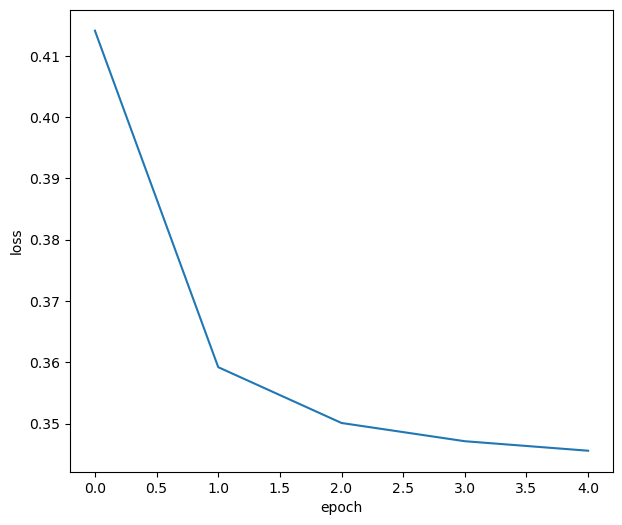

In [26]:
# Plot the training history
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(history.history['loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
_ = plt.show()

<font color='blue'>
Task: Do you think the training was done after 5 epochs? 
</font><br>

<font color='green'>
Answer:<br>
The loss is still significantly decreasing. Thus, the training doesn't seem to reach its limit yet. In the next chapter we will learn how to judge wether the training is done. 
</font>

The model is trained, so the time has come to use it. Let's compare the true classification of some random events and the prediction the model gives for these events.

In [27]:
# Choose some random events
random_idx = [1841, 11852, 63217, 78357, 131697]
print('Classification:')
print(classification[random_idx])
print('Prediction')
print(model.predict(values[random_idx]))

Classification:
[1. 1. 1. 0. 0.]
Prediction
1/1 [==============================] - 0s 69ms/step
[[0.7570616 ]
 [0.448981  ]
 [0.26045036]
 [0.32292578]
 [0.01215063]]


<font color='blue'>
Task: Get the prediction for all events and use <code>common.plot_dnn_output(...)</code> to plot the result.
</font>

In [28]:
# Apply the model for all values
prediction = model.predict(values)

8592/8592 [==============================] - 17s 2ms/step


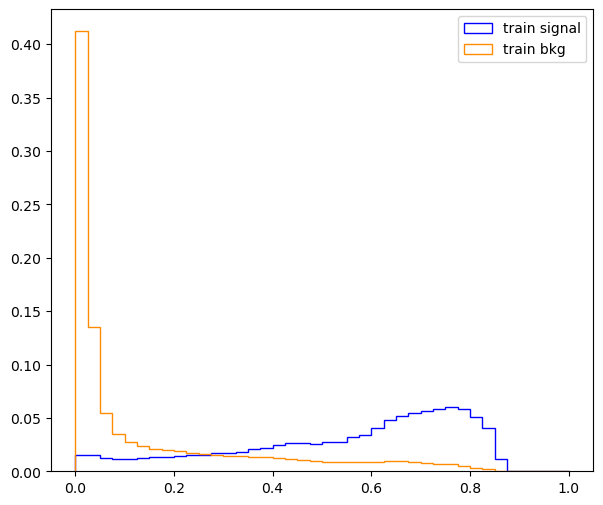

In [29]:
# Plot the model output
common.plot_dnn_output(prediction, classification)
_ = plt.show()

Use `common.apply_dnn_model(...)` to apply the model for all samples in `data_frames` and add the classification to the data frame. Afterwards the prediction can be plotted just as the other kinematic variables.

In [30]:
# Apply the model
data_frames_apply_dnn = common.apply_dnn_model(model, data_frames, training_variables, sample_subset_signal + sample_subset_background)

Apply Model for ggH125_ZZ4lep
5046/5046 [==============================] - 10s 2ms/step
Apply Model for VBFH125_ZZ4lep
5840/5840 [==============================] - 12s 2ms/step
Apply Model for WH125_ZZ4lep
306/306 [==============================] - 1s 2ms/step
Apply Model for ZH125_ZZ4lep
374/374 [==============================] - 1s 2ms/step
Apply Model for llll
16374/16374 [==============================] - 33s 2ms/step
Apply Model for Zee
8/8 [==============================] - 0s 5ms/step
Apply Model for Zmumu
9/9 [==============================] - 0s 5ms/step
Apply Model for ttbar_lep
11/11 [==============================] - 0s 4ms/step


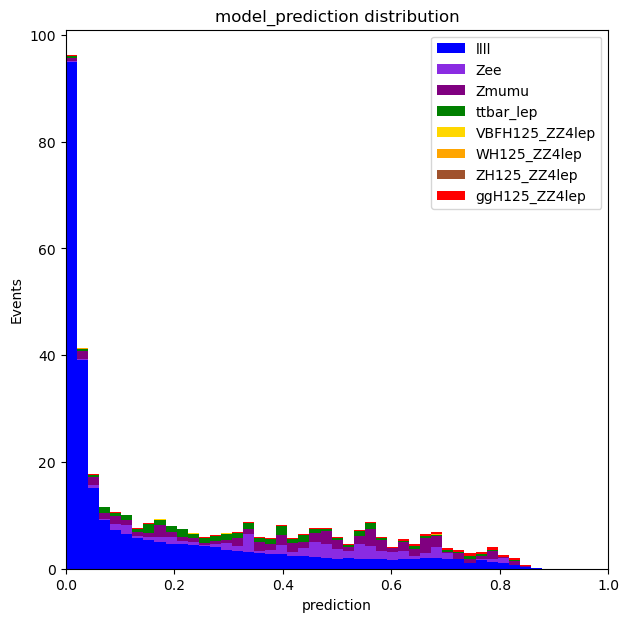

In [31]:
model_prediction = {'variable': 'model_prediction',
                    'binning': np.linspace(0, 1, 50),
                    'xlabel': 'prediction'}
common.plot_hist(model_prediction, data_frames_apply_dnn, show_data=False)

### Validation Data and Early Stopping

How long do we have to train? The right amount of training is very important for the final performance of the network. If the training was too short the model parameters are poorly adapted to the underlying concepts and the model performance is bad. This is called undertraining. If the training was too long the model will start to learn the training data by heart. This overtraining will lead to a very godd performance at the training data but bad performance on unseen data.

Thus, to test the performance of the model the model has to be applied on unseen data. After each epoch the model is the model is applied on validation data not used for training. If the classification of the validation data has improved for the current epoch the model performance is still improving. If the performance on the validation data does not improve anymore the training can be stopped.


# Plot

In [18]:
# Import function to split data into train and test data
from sklearn.model_selection import train_test_split

Use again 40% of the available data for training and additionally 20% to validate the model performance.

In [33]:
# Extract the values, weights and classification of 60% of the data
values, weights, classification = common.get_dnn_input(data_frames, training_variables, sample_list_signal, sample_list_background, 0.6)

In [34]:
# Split into train and validation data
train_values, val_values, train_classification, val_classification = train_test_split(values, classification, test_size=1/3, random_state=random_state)
train_weights, val_weights = train_test_split(weights, classification, test_size=1/3, random_state=random_state)[:2]

<font color='blue'>
Task: Let's follow the same strategy as before:
    
- Create tensorflow data sets for training and validation data with 128 events per batch
- Recreate and adapt the normalization layer
- Recreate the tensorflow model with the same number of layers and nodes per layer
- Compile the model
</font>

In [35]:
# Convert the data to tensorflow datasets
train_data = Dataset.from_tensor_slices((train_values, train_classification))
train_data = train_data.shuffle(len(train_data), seed=random_state)
train_data = train_data.batch(128)
val_data = Dataset.from_tensor_slices((val_values, val_classification))
val_data = val_data.shuffle(len(val_data), seed=random_state)
val_data = val_data.batch(128)

In [36]:
# Normalization layer
normalization_layer = tf.keras.layers.Normalization()
normalization_layer.adapt(train_values)
# Create a simple NN
model_layers = [
    normalization_layer,
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
]
# Create a simple NN
model = tf.keras.models.Sequential(model_layers)
# Compile model
model.compile(optimizer=adam_optimizer, loss=loss_fn, metrics=['binary_accuracy'])

So how to stop the training if the perfomance does not improve anymore?

The answer is early stopping. With early stopping you set a value which should be monitored, in our case the loss on the validation data `val_loss`. Since there can be fluctuations in the tested model performance, it is recommended to use a certain patience after which the training should be stopped. If we set `patience=5` the training is stopped if the `va_loss` has not improved for 5 epochs. Since the model performance has potentionally decreased during this 5 epochs set `restore_best_weights=True` to restore the model state with the best performance.

In [38]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [38]:
# Train model with early stopping for the validation data performance
history = model.fit(train_data, validation_data=val_data, callbacks=[early_stopping], epochs=1000)

Epoch 1/1000
2797/2797 [==============================] - 26s 9ms/step - loss: 0.4883 - binary_accuracy: 0.7709 - val_loss: 0.4754 - val_binary_accuracy: 0.7807
Epoch 2/1000
2797/2797 [==============================] - 27s 10ms/step - loss: 0.4707 - binary_accuracy: 0.7830 - val_loss: 0.4726 - val_binary_accuracy: 0.7815
Epoch 3/1000
2797/2797 [==============================] - 28s 10ms/step - loss: 0.4690 - binary_accuracy: 0.7836 - val_loss: 0.4717 - val_binary_accuracy: 0.7820
Epoch 4/1000
2797/2797 [==============================] - 28s 10ms/step - loss: 0.4681 - binary_accuracy: 0.7836 - val_loss: 0.4713 - val_binary_accuracy: 0.7812
Epoch 5/1000
2797/2797 [==============================] - 28s 10ms/step - loss: 0.4675 - binary_accuracy: 0.7840 - val_loss: 0.4705 - val_binary_accuracy: 0.7825
Epoch 6/1000
2797/2797 [==============================] - 27s 10ms/step - loss: 0.4671 - binary_accuracy: 0.7840 - val_loss: 0.4703 - val_binary_accuracy: 0.7816
Epoch 7/1000
2797/2797 [=====

<font color='blue'>
Task: Plot the training loss (<code>history.history['loss']</code>) and validation loss (<code>history.history['val_loss']</code>) of the training history. Describe what behavior you can observe for each performance trend.
</font>

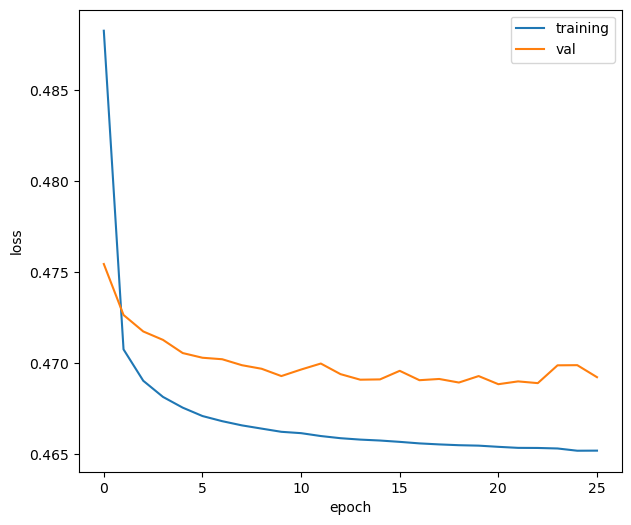

In [39]:
# Plot the training history
fig, ax = plt.subplots(figsize=(7, 6))
# Training loss
ax.plot(history.history['loss'], label='training')
# Validation loss
ax.plot(history.history['val_loss'], label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
_ = plt.show()

The model itself has already an implemented evaluation function. When a tensorflow set is provided it returns the loss and accuracy on this data set.

<font color='blue'>
Task: Evaluate the model on training and validation data and compare the results.
</font>

In [40]:
# Evaluate model on training and validation data
model_train_evaluation = model.evaluate(train_data)
model_val_evaluation = model.evaluate(val_data)

print(f'train loss = {round(model_train_evaluation[0], 5)}\ttrain accuracy = {round(model_train_evaluation[1], 5)}')
print(f'val loss = {round(model_val_evaluation[0], 5)}\tval accuracy = {round(model_val_evaluation[1], 5)}')

1399/1399 [==============================] - 7s 5ms/step - loss: 0.4688 - binary_accuracy: 0.7825
train loss = 0.46506	train accuracy = 0.785
val loss = 0.46883	val accuracy = 0.78247


Now lets apply the model on the train and validation data and plot the classification.

In [41]:
# Apply the model for tarining and validation values
train_prediction = model.predict(train_values)
val_prediction = model.predict(val_values)

5593/5593 [==============================] - 11s 2ms/step


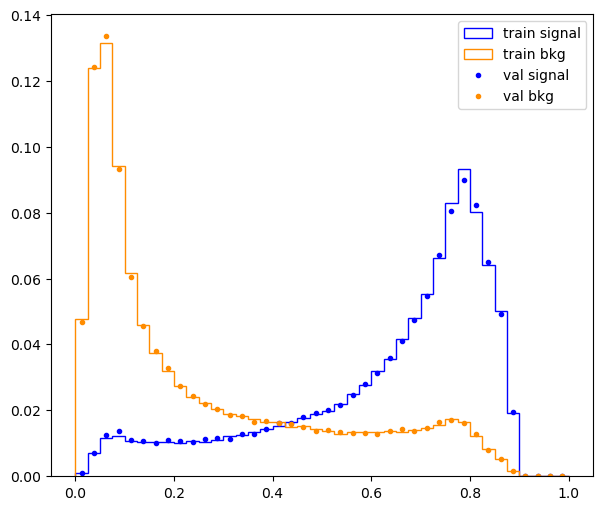

In [42]:
# Plot the model output
common.plot_dnn_output(train_prediction, train_classification, val_prediction, val_classification)
_ = plt.show()

As you can see the classification by the model on traning and validation data is very consistent. This is great :)<br>
If we would see a significant difference in train and validation classification this would be a clear sign for overtraining.

<font color='blue'>
Task: Use <code>common.apply_dnn_model(...)</code> to apply the model for all samples in <code>data_frames</code> and plot the classification.
</font>

In [43]:
# Apply the model
data_frames_apply_dnn = common.apply_dnn_model(model, data_frames, training_variables, sample_subset_signal + sample_subset_background)

Apply Model for ggH125_ZZ4lep
5046/5046 [==============================] - 10s 2ms/step
Apply Model for VBFH125_ZZ4lep
5840/5840 [==============================] - 12s 2ms/step
Apply Model for WH125_ZZ4lep
306/306 [==============================] - 1s 2ms/step
Apply Model for ZH125_ZZ4lep
374/374 [==============================] - 1s 2ms/step
Apply Model for llll
16374/16374 [==============================] - 36s 2ms/step
Apply Model for Zee
8/8 [==============================] - 0s 4ms/step
Apply Model for Zmumu
9/9 [==============================] - 0s 4ms/step
Apply Model for ttbar_lep
11/11 [==============================] - 0s 4ms/step


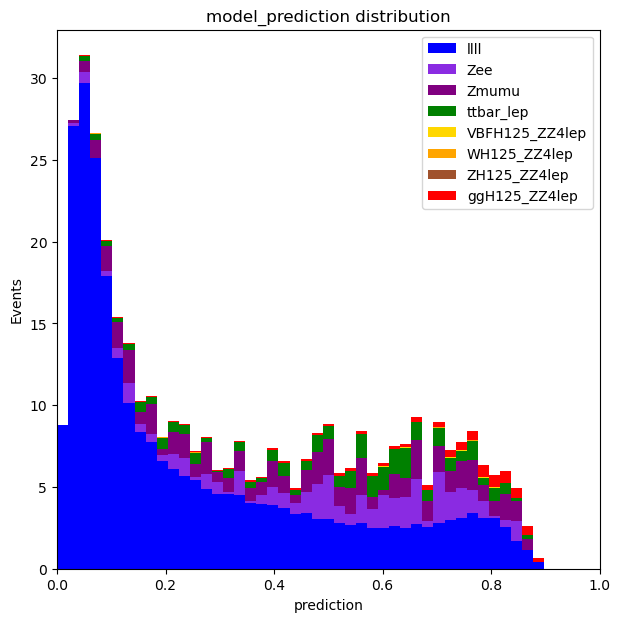

In [44]:
model_prediction = {'variable': 'model_prediction',
                    'binning': np.linspace(0, 1, 50),
                    'xlabel': 'prediction'}
common.plot_hist(model_prediction, data_frames_apply_dnn, show_data=False)

<font color='blue'>
Task:

The llll events are mostly classified as background and the Higgs events tend to the signal classification. However, the classification of Zee and Zmumu events seems to be quite random. What could be the reason for this?
</font><br>

<font color='green'>
Answer:

The number of training events for Zee and Zmumu is much smaller than for the other samples. Thus, they are hardly considered in the training.
</font>

### Event Weights

The simulated events are multiplied by weight factors for the final prediction of measured data. Thus, events with large weights are more important for the prediction than events with small weights. In order to take this into account for the training, the event weights `w_i` can be included in the calculation of the loss:<br>
$H = -\frac{1}{N} \sum_i^N w_i (y_i^{true} log(y_i^{predict}) + (1 - y_i^{true}) log(1 - y_i^{predict}))$

<font color='blue'>
Task: And another time follow the same strategy as before:
    
- Create tensorflow data sets for training and validation data with 128 events per batch. But this time also include the event weights
- Recreate and adapt the normalization layer
- Recreate the tensorflow model with the same number of layers and nodes per layer
- Compile the model
- Train the model
- Plot the classification and do the evaluation
</font>

In [45]:
# Convert the data to tensorflow datasets
train_data = Dataset.from_tensor_slices((train_values, train_classification, train_weights))
train_data = train_data.shuffle(len(train_data), seed=random_state)
train_data = train_data.batch(128)
val_data = Dataset.from_tensor_slices((val_values, val_classification, val_weights))
val_data = val_data.shuffle(len(val_data), seed=random_state)
val_data = val_data.batch(128)

In [46]:
# Normalization layer
normalization_layer = tf.keras.layers.Normalization()
normalization_layer.adapt(train_values)
# Create a simple NN
model_layers = [
    normalization_layer,
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
]
# Create a simple NN
model = tf.keras.models.Sequential(model_layers)
# Compile model now with the weighted metric
model.compile(optimizer=adam_optimizer, loss=loss_fn, weighted_metrics=['binary_accuracy'])

In [47]:
# Train model
history = model.fit(train_data, validation_data=val_data, callbacks=[early_stopping], epochs=1000)

Epoch 1/1000
2797/2797 [==============================] - 30s 11ms/step - loss: 5.0978e-05 - binary_accuracy: 0.9750 - val_loss: 4.4475e-05 - val_binary_accuracy: 0.9755
Epoch 2/1000
2797/2797 [==============================] - 29s 10ms/step - loss: 4.4612e-05 - binary_accuracy: 0.9761 - val_loss: 4.3874e-05 - val_binary_accuracy: 0.9755
Epoch 3/1000
2797/2797 [==============================] - 30s 11ms/step - loss: 4.3977e-05 - binary_accuracy: 0.9761 - val_loss: 4.3306e-05 - val_binary_accuracy: 0.9755
Epoch 4/1000
2797/2797 [==============================] - 30s 11ms/step - loss: 4.3437e-05 - binary_accuracy: 0.9761 - val_loss: 4.3031e-05 - val_binary_accuracy: 0.9755
Epoch 5/1000
2797/2797 [==============================] - 32s 11ms/step - loss: 4.3053e-05 - binary_accuracy: 0.9761 - val_loss: 4.2611e-05 - val_binary_accuracy: 0.9755
Epoch 6/1000
2797/2797 [==============================] - 30s 11ms/step - loss: 4.2688e-05 - binary_accuracy: 0.9761 - val_loss: 4.2374e-05 - val_bina

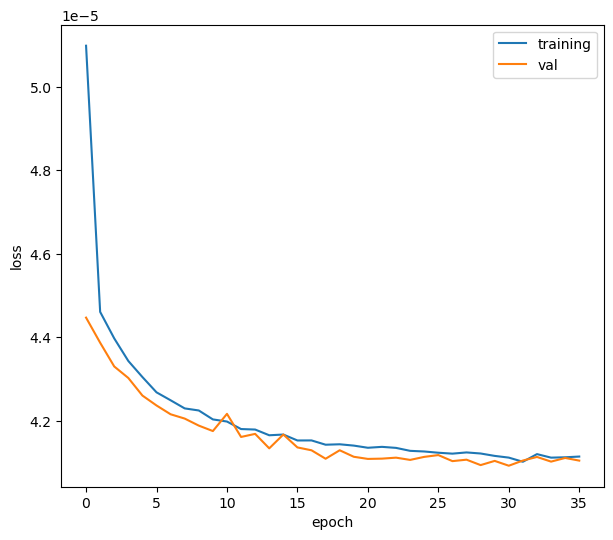

In [48]:
# Plot the training history
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(history.history['loss'], label='training')
ax.plot(history.history['val_loss'], label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
_ = plt.show()

5593/5593 [==============================] - 12s 2ms/step


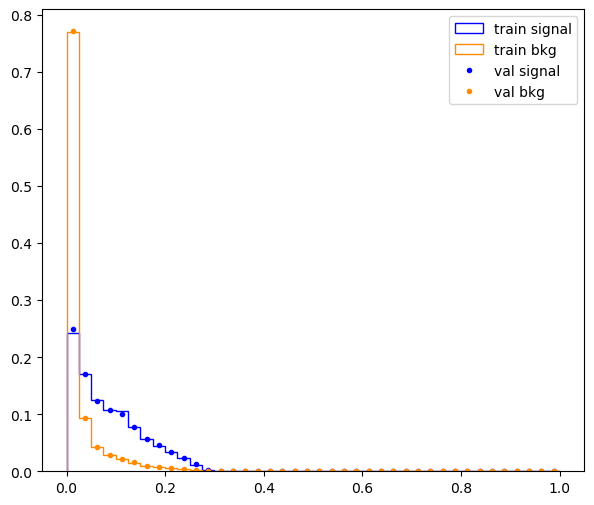

In [49]:
# Apply the model for tarining and validation values
train_prediction = model.predict(train_values)
val_prediction = model.predict(val_values)
# Plot the model output
common.plot_dnn_output(train_prediction, train_classification, val_prediction, val_classification)
_ = plt.show()

In [50]:
# Evaluate
model_train_evaluation = model.evaluate(train_data)
model_val_evaluation = model.evaluate(val_data)

print(f'train loss = {round(model_train_evaluation[0], 5)}\ttrain binary accuracy = {round(model_train_evaluation[1], 5)}')
print(f'val loss = {round(model_val_evaluation[0], 5)}\tval binary accuracy = {round(model_val_evaluation[1], 5)}')

1399/1399 [==============================] - 9s 6ms/step - loss: 4.0933e-05 - binary_accuracy: 0.9755
train loss = 4e-05	train binary accuracy = 0.97612
val loss = 4e-05	val binary accuracy = 0.97554


Apply Model for ggH125_ZZ4lep
5046/5046 [==============================] - 10s 2ms/step
Apply Model for VBFH125_ZZ4lep
5840/5840 [==============================] - 12s 2ms/step
Apply Model for WH125_ZZ4lep
306/306 [==============================] - 1s 2ms/step
Apply Model for ZH125_ZZ4lep
374/374 [==============================] - 1s 2ms/step
Apply Model for llll
16374/16374 [==============================] - 36s 2ms/step
Apply Model for Zee
8/8 [==============================] - 0s 6ms/step
Apply Model for Zmumu
9/9 [==============================] - 0s 5ms/step
Apply Model for ttbar_lep
11/11 [==============================] - 0s 4ms/step


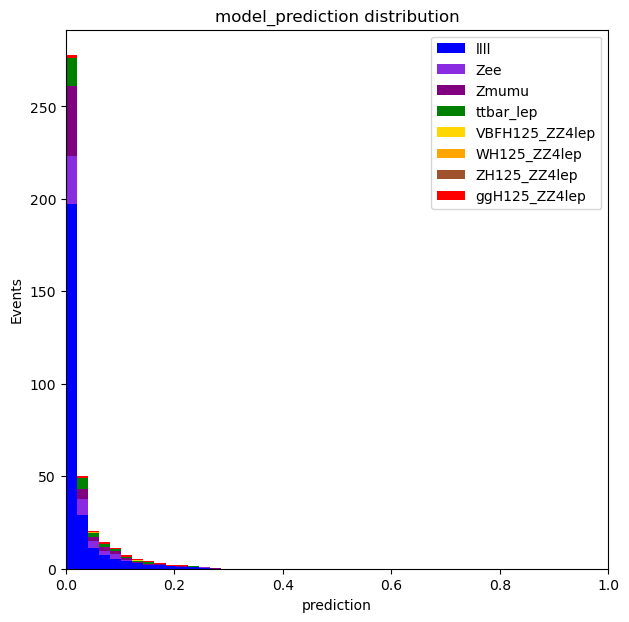

In [52]:
# Apply the model
data_frames_apply_dnn = common.apply_dnn_model(model, data_frames, training_variables, sample_subset_signal + sample_subset_background)
model_prediction = {'variable': 'model_prediction',
                    'binning': np.linspace(0, 1, 50),
                    'xlabel': 'prediction'}
common.plot_hist(model_prediction, data_frames_apply_dnn, show_data=False)

<font color='blue'>
Task:

What differences can you see on the loss, accuarcy and classification distribution? Explain these differences.
</font><br>

<font color='green'>
Answer:

The loss has decreased by the mean weight of the simulated events. The accuracy has significantly improved to 97.5% during the whole training. The reason for this can be seen in the classification plots. Since the weights of signal events are much smaller the model focuses mostly on the classification of background events during the training and therefore classifies all events close to background. With a signal purity of about 2.5% this leads to a accuracy of 97.5%.
</font>

In [61]:
# Check the event weights
mean_signal_weight = weights[classification > 0.5].mean()
mean_background_weight = weights[classification < 0.5].mean()
print(f'The mean weight for signal events is {mean_signal_weight} and for background events {mean_background_weight}')

The mean weight for signal events is 2.6238732618633292e-05 and for background events 0.0007426467420900983


#### Reweight the weights of the simulated data

Introducing the event weights caused the problem that the overall background dominates the training. With the event weights of the simulated data the loss is already quite low if all data is consequently classified close to background.<br>
$H = -\frac{1}{N} \sum_i^N w_i (y_i^{true} log(y_i^{predict}) + (1 - y_i^{true}) log(1 - y_i^{predict}))$

To solve this problem we should reweight the weights to have the same effect on training for signal and background events.

<font color='blue'>
Task:

Write a function that reweights the weights:<br>
1. Take the absolute value of the weight to not run into problems with negative weights
2. Split the weights into signal and background weights (by setting the other weights in the array to zero)
3. Scale the signal weights to have the total sum as the background weights
4. Merge the background and rescaled signal weights
5. Scale all weights to have a mean weight of 1
</font><br>

In [19]:
def reweight_weights(weights, classification):
    # Take the absolute value of the weight
    weights_abs = np.abs(weights)
    # Split in signal and background weights
    weights_signal = weights_abs*classification
    weights_background = weights_abs*(1 - classification)
    # Set ratio of signal and backgroubnd to one
    weights_reweighted = weights_background + weights_signal * sum(weights_background) / sum(weights_signal)
    # Normalize mean weight to one
    weights_reweighted /= weights_reweighted.mean()
    return weights_reweighted

<font color='blue'>
Task:

Test your reweighting function. The mean of all weights should be 1 and the sum of signal weights and background weights should be equal.
</font>

In [63]:
weights_reweighted = reweight_weights(weights, classification)
signal_weights_reweighted = weights_reweighted[classification > 0.5]
background_weights_reweighted = weights_reweighted[classification < 0.5]

print(f'Mean weight: {weights_reweighted.mean()}')
print(f'Signal weight sum: {signal_weights_reweighted.sum()}')
print(f'Background weight sum: {background_weights_reweighted.sum()}')

Mean weight: 1.0000000000000002
Signal weight sum: 268610.9999999979
Background weight sum: 268611.0000000022


<font color='blue'>
Task: And another time follow the same strategy as before:
    
- Create tensorflow data sets for training and validation data with 128 events per batch. Us ethis time the reweighted weights
- Recreate and adapt the normalization layer
- Recreate the tensorflow model with the same number of layers and nodes per layer
- Compile the model
- Train the model
- Plot the classification and do the evaluation
</font>

In [56]:
# Get reweighted weights
train_weights_reweighted = reweight_weights(train_weights, train_classification)
val_weights_reweighted = reweight_weights(val_weights, val_classification)

# Convert the data to tensorflow datasets
train_data = Dataset.from_tensor_slices((train_values, train_classification, train_weights_reweighted))
train_data = train_data.shuffle(len(train_data), seed=random_state)
train_data = train_data.batch(128)
val_data = Dataset.from_tensor_slices((val_values, val_classification, val_weights_reweighted))
val_data = val_data.shuffle(len(val_data), seed=random_state)
val_data = val_data.batch(128)

In [57]:
# Normalization layer
normalization_layer = tf.keras.layers.Normalization()
normalization_layer.adapt(train_values)
# Create a simple NN
model_layers = [
    normalization_layer,
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
]
# Create a simple NN
model = tf.keras.models.Sequential(model_layers)
# Compile model
model.compile(optimizer=adam_optimizer, loss=loss_fn, weighted_metrics=['binary_accuracy'])
# Train model
history = model.fit(train_data, validation_data=val_data, callbacks=[early_stopping], epochs=1000)

Epoch 1/1000
2799/2799 [==============================] - 31s 11ms/step - loss: 0.5489 - binary_accuracy: 0.7231 - val_loss: 0.5259 - val_binary_accuracy: 0.7305
Epoch 2/1000
2799/2799 [==============================] - 31s 11ms/step - loss: 0.5124 - binary_accuracy: 0.7567 - val_loss: 0.4986 - val_binary_accuracy: 0.7727
Epoch 3/1000
2799/2799 [==============================] - 29s 10ms/step - loss: 0.4941 - binary_accuracy: 0.7720 - val_loss: 0.4911 - val_binary_accuracy: 0.7615
Epoch 4/1000
2799/2799 [==============================] - 29s 10ms/step - loss: 0.4851 - binary_accuracy: 0.7752 - val_loss: 0.4807 - val_binary_accuracy: 0.7800
Epoch 5/1000
2799/2799 [==============================] - 29s 10ms/step - loss: 0.4795 - binary_accuracy: 0.7802 - val_loss: 0.4763 - val_binary_accuracy: 0.7831
Epoch 6/1000
2799/2799 [==============================] - 31s 11ms/step - loss: 0.4766 - binary_accuracy: 0.7824 - val_loss: 0.4747 - val_binary_accuracy: 0.7811
Epoch 7/1000
2799/2799 [====

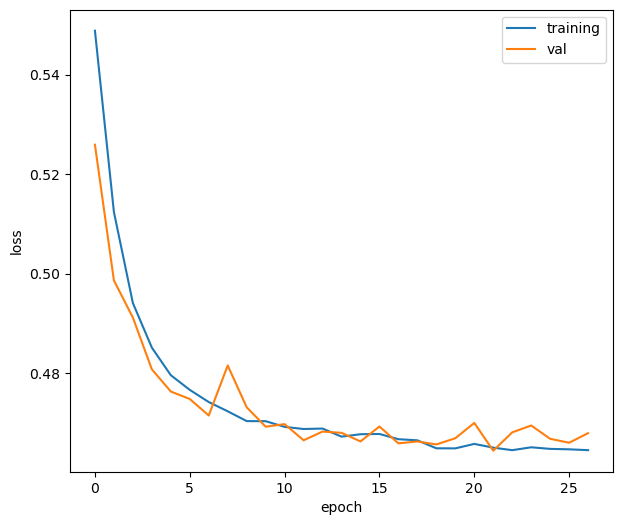

In [64]:
# Plot the training history
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(history.history['loss'], label='training')
ax.plot(history.history['val_loss'], label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
_ = plt.show()

5597/5597 [==============================] - 12s 2ms/step


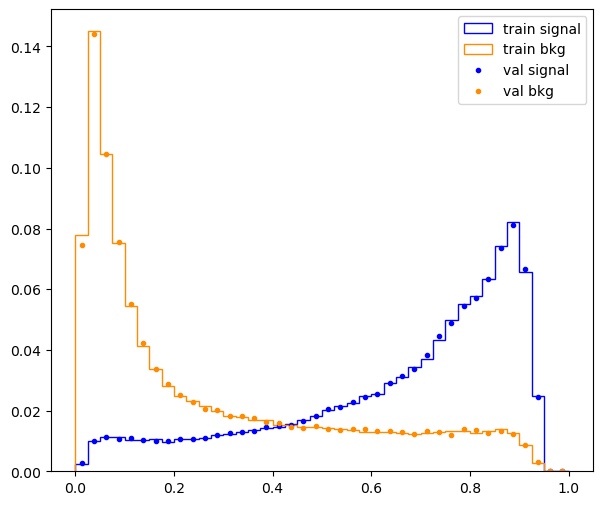

In [65]:
# Apply the model for training and validation values
train_prediction = model.predict(train_values)
val_prediction = model.predict(val_values)
# Plot the model output
common.plot_dnn_output(train_prediction, train_classification, val_prediction, val_classification)
_ = plt.show()

Apply Model for ggH125_ZZ4lep
5046/5046 [==============================] - 10s 2ms/step
Apply Model for llll
16374/16374 [==============================] - 34s 2ms/step
Apply Model for Zee
8/8 [==============================] - 0s 3ms/step
Apply Model for Zmumu
9/9 [==============================] - 0s 3ms/step


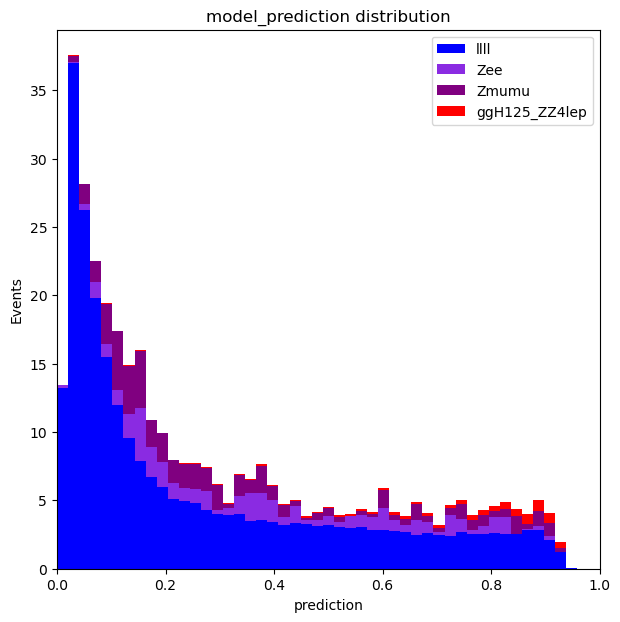

In [68]:
# Apply the model
data_frames_apply_dnn = common.apply_dnn_model(model, data_frames, training_variables, sample_subset_signal + sample_subset_background)
model_prediction = {'variable': 'model_prediction',
                    'binning': np.linspace(0, 1, 50),
                    'xlabel': 'prediction'}
common.plot_hist(model_prediction, data_frames_apply_dnn, show_data=False)

<font color='blue'>
Task:

Compare this classification plot with the one resulting from a training without event weights.
</font><br>

<font color='green'>
Answer:

The overall classification looks quite similar but the classification of Z events has improved.
</font>

## Cross-Validation

If you have a look on the training history you see fluctuations in the validation loss. Furthermore, the validation data set also has a limited size, making it potentially not completely representative for validation.

So how should one evaluate the performance of a model and compare two models?

A commonly used method to evaluate the model performance is k-fold.
The tarining data is split several times with non-overlapping validation sets. On each split a model is trained and validated on the corresponding validation data. This results into several independently trained models with same size and setup validated on different data sets. Thus, one is able to calculate the mean performance of the resulting models.

![kFold.png](figures/kFold.png)

In [29]:
# import the kFold module
from sklearn.model_selection import KFold

Use kFold to split the data 3 times in 2/3 training and 1/3 validation data each randomly shuffled.

In [79]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=3, shuffle=True, random_state=random_state)

Now use kFold to train several models in a for loop. In each loop you have to create a new model and its setup.

<font color='blue'>
Task:

Fill the missing parts in the for loop:
- Reweight the weights
- Convert the values and classification into tensorflow data sets
- Create a model with normalization layer and 2 hidden layers with 60 nodes each
- Compile the model
- Train the model with early stopping
- Evaluate the model on the training and evaluation data
</font><br>

In [80]:
# Store the models and their training history
kfold_history = []
kfold_model = []
# Store the evaluation on training and validation data
kfold_train_eval_loss = []
kfold_train_eval_acc = []
kfold_val_eval_loss = []
kfold_val_eval_acc = []
split_idx = 1
for train_indices, val_indices in kfold.split(values):
    print(f'Use fold {split_idx}')
    split_idx += 1
    # Get train and validation data 
    train_values = values[train_indices]
    train_classification = classification[train_indices]
    train_weights = weights[train_indices]
    val_values = values[val_indices]
    val_classification = classification[val_indices]
    val_weights = weights[val_indices]
    # Get reweighted weights
    train_weights_reweighted = reweight_weights(train_weights, train_classification)
    val_weights_reweighted = reweight_weights(val_weights, val_classification)
    # Get train and validation data 
    train_data = Dataset.from_tensor_slices((train_values, train_classification, train_weights_reweighted))
    train_data = train_data.shuffle(len(train_data), seed=random_state)
    train_data = train_data.batch(124)
    val_data = Dataset.from_tensor_slices((val_values, val_classification, val_weights_reweighted))
    val_data = val_data.shuffle(len(val_data), seed=random_state)
    val_data = val_data.batch(124)

    # Normalization layer
    normalization_layer = tf.keras.layers.Normalization()
    normalization_layer.adapt(train_values)
    # Create a simple NN
    model_layers = [
        normalization_layer,
        tf.keras.layers.Dense(60, activation='relu'),
        tf.keras.layers.Dense(60, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ]

    # Create a simple NN
    model = tf.keras.models.Sequential(model_layers)
    # Compile model
    model.compile(optimizer=adam_optimizer, loss=loss_fn, weighted_metrics=['binary_accuracy'])

    # Train model
    history = model.fit(train_data, validation_data=val_data, callbacks=[early_stopping], epochs=1000)

    # Append to list
    kfold_history.append(history)
    kfold_model.append(model)

    # Evaluate model on training and validation data
    model_train_evaluation = model.evaluate(train_data)
    model_val_evaluation = model.evaluate(val_data)
    kfold_train_eval_loss.append(model_train_evaluation[0])
    kfold_train_eval_acc.append(model_train_evaluation[1])
    kfold_val_eval_loss.append(model_val_evaluation[0])
    kfold_val_eval_acc.append(model_val_evaluation[1])

Use fold 1
Epoch 1/1000
1027/2888 [=========>....................] - ETA: 16s - loss: 0.6020 - binary_accuracy: 0.6947

KeyboardInterrupt: 

Lets plot the training history of the three models.

In [ ]:
# Plot the training history
fig, ax = plt.subplots(figsize=(7, 6))
color_list = ['r', 'g', 'b']
for k_fold_idx, (history, color) in enumerate(zip(kfold_history, color_list)):
  ax.plot(history.history['loss'], color=color, label=f'{k_fold_idx} training')
  ax.plot(history.history['val_loss'], color=color, ls='--', label=f'{k_fold_idx} val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
_ = plt.show()

<font color='blue'>
Task:

Calculate the mean and std of the validation loss.
</font>

In [ ]:
val_loss_mean = np.mean(kfold_val_eval_loss)
val_loss_std = np.std(kfold_val_eval_loss)
print(f'The val loss of the model is {round(val_loss_mean, 3)} +- {round(val_loss_std, 3)}')

## Save and Load a Model

As you have seen training a model takes some time. So retrain a model each time you need it is definitely not the way to go. Instead one should save the model after the training and load it for application.

Saving and loading a model is very straight forward with:<br>
Use `model.save('path/to/location', save_format='h5')` to save a model <br>
and `model = tf.keras.models.load_model('path/to/location')` to load the model

Lets save the three models of the cross validation

In [ ]:
# Loop over all models
for idx, model in enumerate(kfold_model):
    # Save the model
    model.save(f'models/test_crossval_model_{idx}')

Now load one of the models and plot its summary

In [ ]:
model = tf.keras.models.load_model('models/test_crossval_model_0')

model.summary()

## Create Baseline Model

In [68]:
# Use all processes
sample_list_signal = ['ggH125_ZZ4lep', 'VBFH125_ZZ4lep', 'WH125_ZZ4lep', 'ZH125_ZZ4lep']
sample_list_background = ['llll', 'Zee', 'Zmumu', 'ttbar_lep']

In [69]:
# The training input variables
training_variables = ['lep1_pt', 'lep2_pt', 'lep3_pt', 'lep4_pt']
training_variables += ['lep1_e', 'lep2_e', 'lep3_e', 'lep4_e']
training_variables += ['lep1_charge', 'lep2_charge', 'lep3_charge', 'lep4_charge']
training_variables += ['lep1_pdgId', 'lep2_pdgId', 'lep3_pdgId', 'lep4_pdgId']
training_variables += ['lep1_phi', 'lep2_phi', 'lep3_phi', 'lep4_phi']
training_variables += ['lep1_eta', 'lep2_eta', 'lep3_eta', 'lep4_eta']
#training_variables += ['lep_m_ll_12', 'lep_m_ll_13', 'lep_m_ll_14', 'lep_m_ll_23', 'lep_m_ll_24', 'lep_m_ll_34']

In [70]:
values, weights, classification = common.get_dnn_input(data_frames, training_variables, sample_list_signal, sample_list_background, 0.6)

In [71]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=3, shuffle=True, random_state=random_state)

In [72]:
# Store the models and their training history
kfold_history = []
kfold_model = []
# Store the evaluation on training and validation data
kfold_train_eval_loss = []
kfold_train_eval_acc = []
kfold_val_eval_loss = []
kfold_val_eval_acc = []
split_idx = 1
for train_indices, val_indices in kfold.split(values):
    print(f'Use fold {split_idx}')
    split_idx += 1
    # Get train and validation data 
    train_values = values[train_indices]
    train_classification = classification[train_indices]
    train_weights = weights[train_indices]
    val_values = values[val_indices]
    val_classification = classification[val_indices]
    val_weights = weights[val_indices]
    # Get reweighted weights
    train_weights_reweighted = reweight_weights(train_weights, train_classification)
    val_weights_reweighted = reweight_weights(val_weights, val_classification)
    # Get train and validation data 
    train_data = Dataset.from_tensor_slices((train_values, train_classification, train_weights_reweighted))
    train_data = train_data.shuffle(len(train_data), seed=random_state)
    train_data = train_data.batch(124)
    val_data = Dataset.from_tensor_slices((val_values, val_classification, val_weights_reweighted))
    val_data = val_data.shuffle(len(val_data), seed=random_state)
    val_data = val_data.batch(124)

    # Normalization layer
    normalization_layer = tf.keras.layers.Normalization()
    normalization_layer.adapt(train_values)
    # Create a simple NN
    model_layers = [
        normalization_layer,
        tf.keras.layers.Dense(60, activation='relu'),
        tf.keras.layers.Dense(60, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ]

    # Create a simple NN
    model = tf.keras.models.Sequential(model_layers)
    # Compile model
    model.compile(optimizer=adam_optimizer, loss=loss_fn, weighted_metrics=['binary_accuracy'])

    # Train model
    history = model.fit(train_data, validation_data=val_data, callbacks=[early_stopping], epochs=1000)

    # Append to list
    kfold_history.append(history)
    kfold_model.append(model)

    # Evaluate model on training and validation data
    model_train_evaluation = model.evaluate(train_data)
    model_val_evaluation = model.evaluate(val_data)
    kfold_train_eval_loss.append(model_train_evaluation[0])
    kfold_train_eval_acc.append(model_train_evaluation[1])
    kfold_val_eval_loss.append(model_val_evaluation[0])
    kfold_val_eval_acc.append(model_val_evaluation[1])

Use fold 1
Epoch 1/5
2888/2888 [==============================] - 34s 11ms/step - loss: 0.5611 - binary_accuracy: 0.7223 - val_loss: 0.5330 - val_binary_accuracy: 0.7519
Epoch 2/5
2888/2888 [==============================] - 31s 11ms/step - loss: 0.5124 - binary_accuracy: 0.7581 - val_loss: 0.4956 - val_binary_accuracy: 0.7769
Epoch 3/5
2888/2888 [==============================] - 31s 11ms/step - loss: 0.4775 - binary_accuracy: 0.7782 - val_loss: 0.4656 - val_binary_accuracy: 0.7859
Epoch 4/5
2888/2888 [==============================] - 32s 11ms/step - loss: 0.4463 - binary_accuracy: 0.7976 - val_loss: 0.4408 - val_binary_accuracy: 0.8037
Epoch 5/5
1444/1444 [==============================] - 8s 6ms/step - loss: 0.4198 - binary_accuracy: 0.8135
Use fold 2
Epoch 1/5
2888/2888 [==============================] - 32s 11ms/step - loss: 0.5758 - binary_accuracy: 0.7097 - val_loss: 0.5573 - val_binary_accuracy: 0.7277
Epoch 2/5
2888/2888 [==============================] - 31s 11ms/step - loss

In [74]:
# Loop over all models
for idx, model in enumerate(kfold_model):
    # Save the model
    model.save(f'baseline_models/crossval_model_{idx}')

INFO:tensorflow:Assets written to: baseline_models/crossval_model_0/assets
INFO:tensorflow:Assets written to: baseline_models/crossval_model_1/assets
INFO:tensorflow:Assets written to: baseline_models/crossval_model_2/assets


In [62]:
print('Train loss')
print(kfold_train_eval_loss)
print(np.mean(kfold_train_eval_loss))
print(f'The train loss of the model is {round(np.mean(kfold_train_eval_loss), 5)} +- {round(np.std(kfold_train_eval_loss), 5)}\n')
print('Val loss')
print(kfold_val_eval_loss)
print(np.mean(kfold_val_eval_loss))
print(f'The val loss of the model is {round(np.mean(kfold_val_eval_loss), 5)} +- {round(np.std(kfold_val_eval_loss), 5)}\n')
print('Train acc')
print(kfold_train_eval_acc)
print(np.mean(kfold_train_eval_acc))
print(f'The train acc of the model is {round(np.mean(kfold_train_eval_acc), 5)} +- {round(np.std(kfold_train_eval_acc), 5)}\n')
print('Val acc')
print(kfold_val_eval_acc)
print(np.mean(kfold_val_eval_acc))
print(f'The val acc of the model is {round(np.mean(kfold_val_eval_acc), 5)} +- {round(np.std(kfold_val_eval_acc), 5)}\n')

Train loss
[0.2114640474319458, 0.2193506956100464, 0.21764697134494781]
0.21615390479564667
The train loss of the model is 0.21615 +- 0.00339

Val loss
[0.25950804352760315, 0.29206204414367676, 0.2819792926311493]
0.27784979343414307
The val loss of the model is 0.27785 +- 0.01361

Train acc
[0.9294561147689819, 0.9246068000793457, 0.9267025589942932]
0.9269218246142069
The train acc of the model is 0.92692 +- 0.00199

Val acc
[0.903923749923706, 0.8790167570114136, 0.8887717723846436]
0.8905707597732544
The val acc of the model is 0.89057 +- 0.01025



Train loss: `[0.2114640474319458, 0.2193506956100464, 0.21764697134494781]`<br>
Train loss mean: `0.21615390479564667`<br>
The train loss of the model is 0.21615 +- 0.00339

Val loss: `[0.25950804352760315, 0.29206204414367676, 0.2819792926311493]`<br>
Val loss mean: `0.27784979343414307`<br>
The val loss of the model is 0.27785 +- 0.01361

Train acc: `[0.9294561147689819, 0.9246068000793457, 0.9267025589942932]`<br>
Train acc mean: `0.9269218246142069`<br>
The train acc of the model is 0.92692 +- 0.00199

Val acc: `[0.903923749923706, 0.8790167570114136, 0.8887717723846436]`<br>
Val acc mean: `0.8905707597732544`<br>
The val acc of the model is 0.89057 +- 0.01025

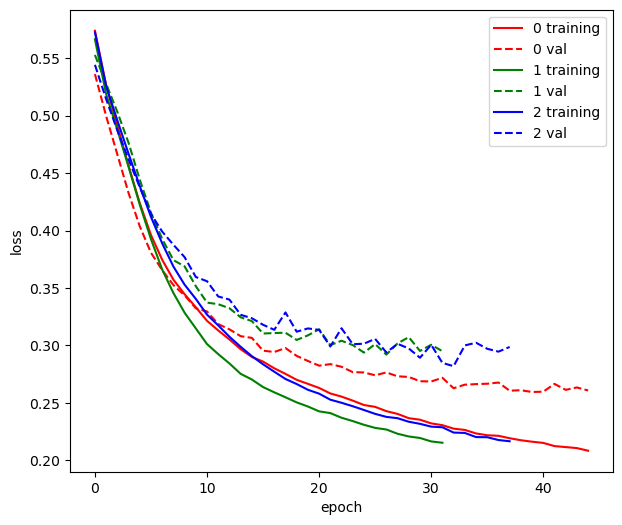

In [52]:
# Plot the training history
fig, ax = plt.subplots(figsize=(7, 6))
color_list = ['r', 'g', 'b']
for k_fold_idx, (history, color) in enumerate(zip(kfold_history, color_list)):
  ax.plot(history.history['loss'], color=color, label=f'{k_fold_idx} training')
  ax.plot(history.history['val_loss'], color=color, ls='--', label=f'{k_fold_idx} val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
fig.savefig('baseline_models/training_history.png', dpi=300)
_ = plt.show()

## Train your own Model

Now it is your turn to create your own model to hunt for the Higgs boson. For the beginning, we will have a look on a baseline model. This baseline model does already a good job in the classification and it is up to you to create a better one.

<font color='blue'>
Task:

1. Use reweighted event weights for your training
2. Choose a setup for your model
3. Train your model with early stopping
4. Plot the training history and check your validation loss <br>
    If the validation loss is not better than for the baseline model by two standard deviations of the baseline validation loss: go back to step 2.
5. Validate your results with cross validation and calculate the mean validation loss and its standard deviation
    If the loss is not significantly better than for the baseline model: go back to step 2.
</font>

### Baseline Model

Lets load the baseline models. The baseline model was trained with cross validation on 40% of the data for training and 20% of the total data for validation.

The val loss of the model is 0.27785 +- 0.01361.

In [76]:
baseline_models = []
for idx in range(3):
    print(f'baseline_models/crossval_model_{idx}')
    model = tf.keras.models.load_model(f'baseline_models/crossval_model_{idx}')
    baseline_models.append(model)

baseline_models/crossval_model_0
baseline_models/crossval_model_1
baseline_models/crossval_model_2


### Training input

<font color='blue'>
Task:

Train your model for all processes on all <u><b>low level</b></u> variables.
</font>

In [85]:
# Use all processes
sample_list_signal = ['ggH125_ZZ4lep', 'VBFH125_ZZ4lep', 'WH125_ZZ4lep', 'ZH125_ZZ4lep']
sample_list_background = ['llll', 'Zee', 'Zmumu', 'ttbar_lep']

In [86]:
# The training input variables
training_variables = ['jet_n']
training_variables += ['lep1_pt', 'lep2_pt', 'lep3_pt', 'lep4_pt']
training_variables += ['lep1_e', 'lep2_e', 'lep3_e', 'lep4_e']
training_variables += ['lep1_charge', 'lep2_charge', 'lep3_charge', 'lep4_charge']
training_variables += ['lep1_pdgId', 'lep2_pdgId', 'lep3_pdgId', 'lep4_pdgId']
training_variables += ['lep1_phi', 'lep2_phi', 'lep3_phi', 'lep4_phi']
training_variables += ['lep1_eta', 'lep2_eta', 'lep3_eta', 'lep4_eta']

Use again 40% of the data for training and 20% for validation. If you want to improve your training on a later point you can also use 80% for training and 20% for validation.

In [87]:
values, weights, classification = common.get_dnn_input(data_frames, training_variables, sample_list_signal, sample_list_background, 0.6)

If you want you can play around with the batch size

In [89]:
# Get reweighted weights
train_weights_reweighted = reweight_weights(train_weights, train_classification)
val_weights_reweighted = reweight_weights(val_weights, val_classification)

# Convert the data to tensorflow datasets
train_data = Dataset.from_tensor_slices((train_values, train_classification, train_weights_reweighted))
train_data = train_data.shuffle(len(train_data), seed=random_state)
train_data = train_data.batch(128)
val_data = Dataset.from_tensor_slices((val_values, val_classification, val_weights_reweighted))
val_data = val_data.shuffle(len(val_data), seed=random_state)
val_data = val_data.batch(128)

In [90]:
# Split into train and validation data
train_values, val_values, train_classification, val_classification = train_test_split(values, classification, test_size=1/3, random_state=random_state)
train_weights, val_weights = train_test_split(weights, classification, test_size=1/3, random_state=random_state)[:2]

### Model Setup

You can change the learning rate of the optimizer to improve your training

In [91]:
# Loss function
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# Optimizer
adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.9)

Create your model

In [92]:
# Normalization layer
normalization_layer = tf.keras.layers.Normalization()
normalization_layer.adapt(train_values)
# Create a simple NN
model_layers = [
    normalization_layer,
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
]
# Create a simple NN
model = tf.keras.models.Sequential(model_layers)
# Compile model
model.compile(optimizer=adam_optimizer, loss=loss_fn, weighted_metrics=['binary_accuracy'])

### Training

In [ ]:
# Train model
history = model.fit(train_data, validation_data=val_data, callbacks=[early_stopping], epochs=1000)

Epoch 1/1000
 243/2791 [=>............................] - ETA: 25s - loss: 0.6654 - binary_accuracy: 0.6161

In [27]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=3, shuffle=True, random_state=random_state)

In [26]:
values, weights, classification = common.get_dnn_input(data_frames, training_variables, sample_list_signal, sample_list_background, 0.6)

In [77]:
train_values, val_values, train_classification, val_classification = train_test_split(values, classification, test_size=0.2, random_state=123)
train_weights, val_weights = train_test_split(weights, classification, test_size=0.2, random_state=123)[:2]

In [99]:
# Get reweighted weights
train_weights_reweighted = reweight_weights(train_weights, train_classification)
val_weights_reweighted = reweight_weights(val_weights, val_classification)

# Convert the data to tensorflow datasets
train_data = Dataset.from_tensor_slices((train_values, train_classification, train_weights_reweighted))
train_data = train_data.shuffle(len(train_data), seed=random_state)
train_data = train_data.batch(128)
val_data = Dataset.from_tensor_slices((val_values, val_classification, val_weights_reweighted))
val_data = val_data.shuffle(len(val_data), seed=random_state)
val_data = val_data.batch(128)

In [100]:
# Loss function
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# Optimizer
adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005, beta_1=0.9)

In [101]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [102]:
# Normalization layer
normalization_layer = tf.keras.layers.Normalization()
normalization_layer.adapt(train_values)
# Create a simple NN
model_layers = [
    normalization_layer,
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
]
# Create a simple NN
model = tf.keras.models.Sequential(model_layers)
# Compile model
model.compile(optimizer=adam_optimizer, loss=loss_fn, weighted_metrics=['binary_accuracy'])

In [103]:
# Train model
history = model.fit(train_data, validation_data=val_data, callbacks=[early_stopping], epochs=1000)

Epoch 1/1000
5593/5593 [==============================] - 58s 10ms/step - loss: 0.5054 - binary_accuracy: 0.7580 - val_loss: 0.4258 - val_binary_accuracy: 0.8031
Epoch 2/1000
5593/5593 [==============================] - 53s 9ms/step - loss: 0.3684 - binary_accuracy: 0.8430 - val_loss: 0.3547 - val_binary_accuracy: 0.8488
Epoch 3/1000
5593/5593 [==============================] - 54s 10ms/step - loss: 0.3184 - binary_accuracy: 0.8698 - val_loss: 0.3170 - val_binary_accuracy: 0.8738
Epoch 4/1000
5593/5593 [==============================] - 57s 10ms/step - loss: 0.2935 - binary_accuracy: 0.8816 - val_loss: 0.3078 - val_binary_accuracy: 0.8792
Epoch 5/1000
5593/5593 [==============================] - 51s 9ms/step - loss: 0.2778 - binary_accuracy: 0.8910 - val_loss: 0.2971 - val_binary_accuracy: 0.8816
Epoch 6/1000
5593/5593 [==============================] - 54s 10ms/step - loss: 0.2658 - binary_accuracy: 0.8977 - val_loss: 0.2958 - val_binary_accuracy: 0.8822
Epoch 7/1000
5593/5593 [======

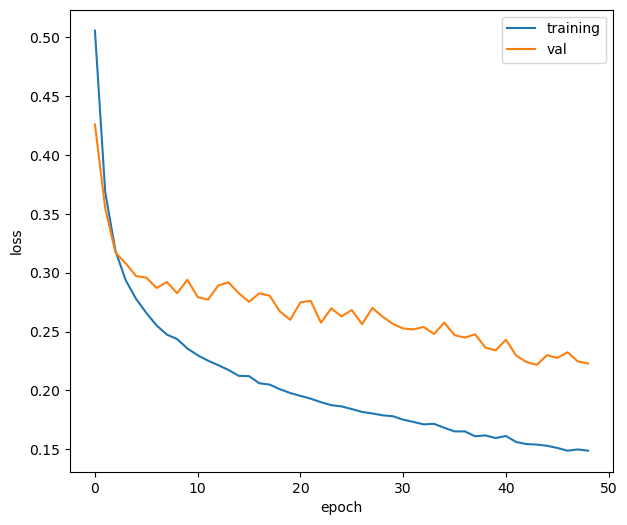

In [104]:
# Plot the training history
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(history.history['loss'], label='training')
ax.plot(history.history['val_loss'], label='val')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
_ = plt.show()

5593/5593 [==============================] - 12s 2ms/step


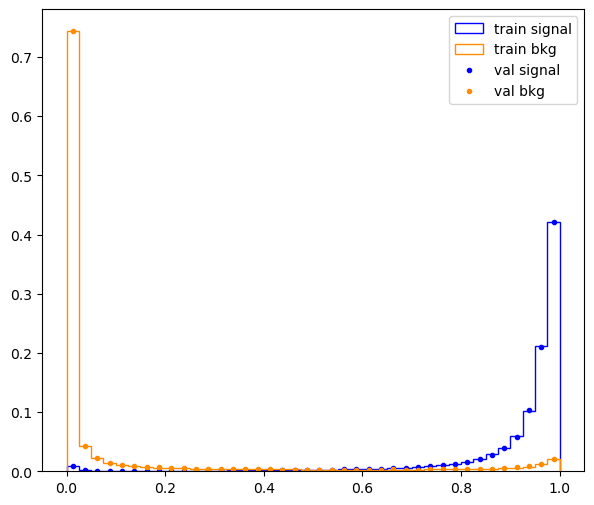

In [107]:
# Apply the model for training and validation values
train_prediction = model.predict(train_values)
val_prediction = model.predict(val_values)
# Plot the model output
common.plot_dnn_output(train_prediction, train_classification, val_prediction, val_classification)
_ = plt.show()

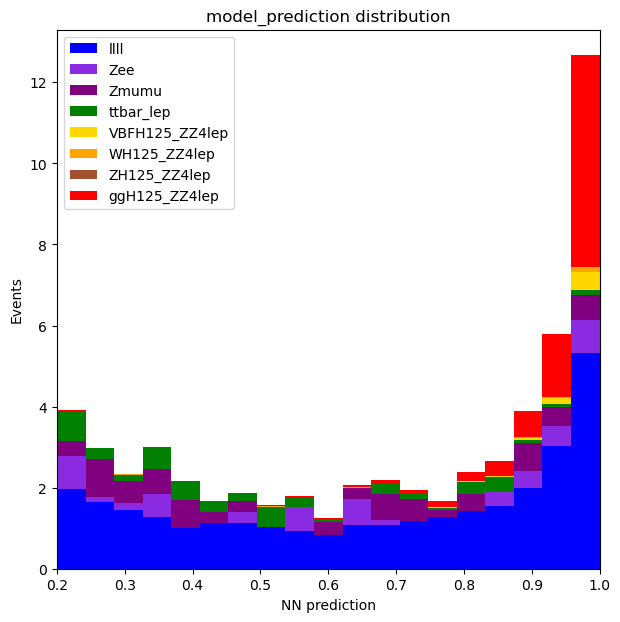

In [115]:
# Apply the model
#data_frames_apply_dnn = apply_dnn_model(model, data_frames, training_variables, sample_list_signal + sample_list_background)
model_prediction = {'variable': 'model_prediction',
                    'binning': np.linspace(0.2, 1, 20),
                    'xlabel': 'NN prediction'}
common.plot_hist(model_prediction, data_frames_apply_dnn, show_data=False)

## Training

In this chapter, the DNN is trained. Define the input variables for the classification. Feel free to test different combinations of low-level and high-level variables. Additionally, you can modify the structure of the DNN to gain optimal training results. When the setup is done, train the DNN, test it and redo this until you are happy with the result.

In [ ]:
# The training input variables
training_variables = ['lep1_pt', 'lep2_pt', 'lep3_pt', 'lep4_pt']
training_variables += ['lep1_charge', 'lep2_charge', 'lep3_charge', 'lep4_charge']
training_variables += ['lep1_pdgId', 'lep2_pdgId', 'lep3_pdgId', 'lep4_pdgId']
training_variables += ['lep1_phi', 'lep2_phi', 'lep3_phi', 'lep4_phi']
training_variables += ['lep1_eta', 'lep2_eta', 'lep3_eta', 'lep4_eta']
training_variables += ['lep_m_ll_12', 'lep_m_ll_13', 'lep_m_ll_14', 'lep_m_ll_23', 'lep_m_ll_24', 'lep_m_ll_34']

In [ ]:
# Create the training input
values = []
weights = []
classification = []
for sample in sample_list_signal + sample_list_background:
    # Classify signal and background (and skip if data)
    if sample in sample_list_signal:
        # 1 if signal
        classification.append(np.ones(len(data_frames[sample])))
    elif sample in sample_list_background:
        # 0 if background
        classification.append(np.zeros(len(data_frames[sample])))
    else:
        continue
    # input values
    values.append(data_frames[sample][training_variables])
    weights.append(data_frames[sample]['totalWeight'])

# Merge the input
values = np.concatenate(values)
weights = np.concatenate(weights)
classification = np.concatenate(classification)

The data set is split in a training, test and validation set. To have enough data to train use a splitting of 80%:10%:10%

In [ ]:
from sklearn.model_selection import train_test_split

Rescale the weights and keep the sample ratio?

In [ ]:
def reweight_weights(weights, classification):
    # Take the absolute weight
    weights_abs = np.abs(weights)
    # Split in signal and background weights
    weights_signal = weights_abs*classification
    weights_background = weights_abs*(1 - classification)
    # Set ratio of signal and backgroubnd to one
    weights_reweighted = weights_background + weights_signal * sum(weights_background) / sum(weights_signal)
    # Normalize mean weight to one
    weights_reweighted /= weights_reweighted.mean()
    return weights_reweighted

In [ ]:
random_state = 100

# Train data
train_values, test_val_values, train_classification, test_val_classification = train_test_split(values, classification, test_size=0.2, random_state=random_state)
train_weights, test_val_weights = train_test_split(weights, classification, test_size=0.2, random_state=random_state)[:2]

# Test and validation data
test_values, val_values, test_classification, val_classification = train_test_split(test_val_values, test_val_classification, test_size=0.5, random_state=random_state)
test_weights, val_weights = train_test_split(test_val_weights, test_val_classification, test_size=0.5, random_state=random_state)[:2]

# Get reweighted weights
train_weights_reweighted = reweight_weights(train_weights, train_classification)
test_weights_reweighted = reweight_weights(test_weights, test_classification)
val_weights_reweighted = reweight_weights(val_weights, val_classification)

In [ ]:
# scale inputs
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_values)
train_values = scaler.transform(train_values)
test_values = scaler.transform(test_values)
val_values = scaler.transform(val_values)

In [ ]:
# Import the tensorflow module to create a DNN

import tensorflow as tf
import pandas as pd
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

Create you DNN consisting of several layers. 

A full list of layer types can be found here https://www.tensorflow.org/api_docs/python/tf/keras/layers <br>
Some important examples for layers are:
- Dense: a densely connected NN layer
- Flatten: flattens the input
- Dropout: randomly sets input to 0. Can decrease overtraining

The neurons of each layer are activated by the so called activation function. <br>
A full list of provided activation functions can be found here https://www.tensorflow.org/api_docs/python/tf/keras/activations <br>
Some examples are:
- linear: $linear(x) = x$
- relu: linear for $x>0$ ($relu(x) = max(0, x)$)
- exponential: $exponential(x) = e^x$
- sigmoid: $sigmoid(x) = 1 / (1 + e^{-x})$

To classify background and signal the last layer should only consist of one neuron which has an activation between 0 and 1

In [ ]:
def get_model(n_layers, n_nodes):
    model_layers = []
    for i_layer in range(n_layers):
        model_layers.append(tf.keras.layers.Dense(n_nodes, activation='relu'))
    model_layers.append(tf.keras.layers.Dense(1, activation='sigmoid'))
    model = tf.keras.models.Sequential(model_layers)
    return model

In [ ]:
import itertools
n_layers = [2, 4, 6]
n_nodes = [10, 50, 100]
n_layers = [4, 6, 8]
n_nodes = [20, 40, 60]
n_layers = [7, 8, 10]
n_nodes = [10, 20, 30]
n_layers = [8]
n_nodes = [10]
hyper_parameters = list(itertools.product(n_layers, n_nodes))
print(hyper_parameters)
models = {}
for (n_layers, n_nodes) in hyper_parameters:
    model_name = f'dnn_{str(n_layers)}_{str(n_nodes)}'
    models[model_name] = {'model': get_model(n_layers, n_nodes)}

While training, the parameters of the neural network are modified to increase the agreement between the classification of the training data by the neural network and the actual splitting in signal and background. 
The agreement is specified by a loss-function, which decreses with increasing agreement. Analogous to a Chi2 fit, the fit to the training data is done by determining the minimum of the loss-function. The choice of the specific loss-function has to be adapted to the problem the neural network has to solve. <br>

The list of available loss-functions are listed here https://www.tensorflow.org/api_docs/python/tf/keras/losses
For the binary (0 or 1) classification problem of the signal background separation the BinaryCrossentropy is used. <br>
<b> Give more information!!! </b>

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

For the optimization of the loss-function different optimization algorithms can be used (see https://www.tensorflow.org/api_docs/python/tf/keras/optimizers). <br>
The performance of the learning process is given by the metric (see https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [ ]:
for model_name in models:
    models[model_name]['model'].compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.9),
                                        loss=loss_fn,
                                        weighted_metrics=['binary_accuracy'])

Early stopping

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
for model_name in models:
    print(f'Start training for {model_name}:')
    history = models[model_name]['model'].fit(train_values, train_classification, sample_weight=train_weights_reweighted, validation_data=(val_values, val_classification, val_weights_reweighted), callbacks=[early_stopping], epochs=1000)
    models[model_name]['history'] = history

In [ ]:
color_list = ['red', 'orange', 'blue', 'peru', 'purple', 'lime', 'cyan', 'darkgreen', 'darkred']
model_list = list(models.keys())
model_colors = {}
for i in range(len(models)):
    model_name = model_list[i]
    model_colors[model_name] = color_list[i]

for model_name in models:
    plt.plot(models[model_name]['history'].history['loss'], color=model_colors[model_name], linestyle='--', linewidth=0.8)
    plt.plot(models[model_name]['history'].history['val_loss'], label=f'{model_name}', color=model_colors[model_name], linewidth=0.8)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
layers_string = str(n_layers).replace(' ', '')
nodes_string = str(n_nodes).replace(' ', '')
plt.tight_layout()
plt.savefig(f'plots/layers_{layers_string}_nodes_{nodes_string}_train_comparison.pdf')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Evaluate the Model

In [ ]:
from sklearn import metrics

In [ ]:
for model_name in models:
    # ROC curve
    val_prediction = models[model_name]['model'].predict(val_values)
    fpr, tpr, thresholds = metrics.roc_curve(val_classification, val_prediction, sample_weight=val_weights_reweighted)
    roc_auc = metrics.auc(fpr, tpr)
    models[model_name]['roc_auc'] = roc_auc
    
    # Model history
    history_train_loss = models[model_name]['history'].history['loss']
    history_train_accuracy = models[model_name]['history'].history['binary_accuracy']
    history_val_loss = models[model_name]['history'].history['val_loss']
    history_val_accuracy = models[model_name]['history'].history['val_binary_accuracy']
    
    # Model evaluation
    val_loss, val_accuracy = models[model_name]['model'].evaluate(val_values, val_classification, sample_weight=val_weights_reweighted)
    train_loss, train_accuracy = models[model_name]['model'].evaluate(train_values, train_classification, sample_weight=train_weights_reweighted)
    
    models[model_name]['roc_auc'] = roc_auc
    models[model_name]['history_train_loss'] = history_train_loss
    models[model_name]['history_train_accuracy'] = history_train_accuracy
    models[model_name]['history_val_loss'] = history_val_loss
    models[model_name]['history_val_accuracy'] = history_val_accuracy
    models[model_name]['train_loss'] = train_loss
    models[model_name]['train_accuracy'] = train_accuracy
    models[model_name]['val_loss'] = val_loss
    models[model_name]['val_accuracy'] = val_accuracy
    print(f'{model_name}: \tROC = {round(roc_auc, 3)}  \tval_loss = {round(val_loss,3)} \tval_acc = {round(val_accuracy*100,1)}% \tval/train_loss = {round(val_loss/train_loss,3)}')

In [ ]:
import seaborn as sns

evaluation_full = {'roc_auc': [],'n_layers': [], 'n_nodes': [], 'roc_auc': [], 'val_loss': [], 'val_accuracy': [], 'val/train_loss': []}

for model_name in models:
    eval_n_layers = int(model_name.split('_')[1])
    eval_n_nodes = int(model_name.split('_')[2])
    evaluation_full['n_layers'].append(eval_n_layers)
    evaluation_full['n_nodes'].append(eval_n_nodes)
    evaluation_full['roc_auc'].append(models[model_name]['roc_auc'])
    evaluation_full['val_loss'].append(models[model_name]['val_loss'])
    evaluation_full['val_accuracy'].append(models[model_name]['val_accuracy'])
    evaluation_full['val/train_loss'].append(models[model_name]['val_loss']/models[model_name]['train_loss'])

evaluation_full_df = pd.DataFrame(evaluation_full)

for eval in ['roc_auc', 'val_loss', 'val_accuracy', 'val/train_loss']:
    pivot = evaluation_full_df.pivot(index='n_layers', columns='n_nodes', values=eval)
    sns.heatmap(pivot, cbar_kws={'label': eval}, cmap='crest')
    plt.title(eval)
    
    eval_string = eval.replace('/', '_')
    layers_string = str(list(set(evaluation_full_df['n_layers']))).replace(' ', '')
    nodes_string = str(list(set(evaluation_full_df['n_nodes']))).replace(' ', '')
    plt.savefig(f'plots/layers_{layers_string}_nodes_{nodes_string}_evaluate_{eval_string}.pdf')
    plt.show()

In [ ]:
def get_prediction_signal_background(model, values, weights, classifications, scale=1):
    predictions = model.predict(values)
    signal_prediction = []
    signal_weight = []
    background_prediction = []
    background_weight = []
    for prediction, weight, classification in zip(predictions, weights, classifications):
        if classification == 1:
            signal_prediction.append(prediction[0])
            signal_weight.append(weight)
        else:
            background_prediction.append(prediction[0])
            background_weight.append(weight)
    prediction = [np.array(background_prediction), np.array(signal_prediction)]
    weights = [np.array(background_weight)*scale, np.array(signal_weight)*scale]
    return prediction, weights

In [ ]:
binning = np.linspace(0.9, 1, 11)
for model_name in models:
    # ROC curve
    model = models[model_name]['model']
    prediction, weights = get_prediction_signal_background(model, val_values, val_weights, val_classification, scale=10)
    plt.hist(prediction, weights=weights,
             label=['val background', 'val signal'], color=['blue', 'red'],
             bins=binning, alpha = 0.4, stacked=True)
    prediction, weights = get_prediction_signal_background(model, train_values, train_weights, train_classification, scale=1/0.8)
    plt.hist(prediction, weights=weights,
             label=['train background', 'train signal'], color=['green', 'sienna'], histtype='step',
             bins=binning, stacked=True)
    plt.title(model_name)
    plt.xlabel('DNN output')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(f'plots/{model_name}_val_prediction.pdf')
    plt.show()
    _ = plt.clf()

# Validation

In [ ]:
binning = np.linspace(0.9, 1, 11)
for model_name in models:
    # ROC curve
    model = models[model_name]['model']
    prediction, weights = get_prediction_signal_background(model, test_values, test_weights, test_classification, scale=10)
    plt.hist(prediction, weights=weights,
             label=['test background', 'test signal'], color=['blue', 'red'],
             bins=binning, alpha = 0.2, stacked=True)
    prediction, weights = get_prediction_signal_background(model, val_values, val_weights, val_classification, scale=10)
    plt.hist(prediction, weights=weights,
             label=['val background', 'val signal'], color=['violet', 'orange'],
             bins=binning, stacked=True, histtype='step')
    prediction, weights = get_prediction_signal_background(model, train_values, train_weights, train_classification, scale=1/0.8)
    plt.hist(prediction, weights=weights,
             label=['train background', 'train signal'], color=['green', 'sienna'], histtype='step',
             bins=binning, stacked=True)
    plt.title(model_name)
    plt.xlabel('DNN output')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(f'plots/{model_name}_test_prediction.pdf')
    plt.show()
    _ = plt.clf()

# Apply to Model

In [ ]:
# Create a copy of the data frame
data_frames_apply_dnn = data_frames.copy()

for sample in sample_list_signal + sample_list_background + sample_list_measured:
    print(f'Apply Model for {sample}')
    # Get the values to apply the model
    data_frame_values = data_frames_apply_dnn[sample][training_variables]
    for model in models:
        prediction = models[model]['model'].predict(scaler.transform(data_frame_values))
    
        # Convert prediction to array
        prediction = [element[0] for element in prediction]
    
        # Add the prediction for each sample
        data_frames_apply_dnn[sample][f'{model}_prediction'] = prediction

In [ ]:
for model in models:
    print(model)
    variable = {'variable': f'{model}_prediction',
               'binning': np.linspace(0.7, 1, 11),#dnn_binning[model],
               'xlabel': f'{model} prediction'}
    common.plot_hist(variable, data_frames_apply_dnn)
    _ = plt.clf()